# Time Domain

The time domain refers to the perspective where a sound is viewed as a waveform, which is simply a changing pressure over a period of time. There are many ways to describe the qualities, especially strength, of a waveform. This section provides a simple overview of some of these metrics, their theoretical basis, and how to calculate them in matlab. The final portion provides some hands-on examples for how to apply these metrics, and hopefully demonstrates that metrics must be chosen carefully, as not all metrics are appropriate for all signals.

## Definitions


### Energy

The energy of a signal, $E$, is its ability to do work. It is typically expressed in `Joules`. It can be helpful to think of this quantity as the 'area under the curve' of that signal in the time domain.

The energy of a **continuous** complex signal can be described as follows:

\begin{equation}
     E = \int_{-\infty}^{\infty} |y(t)|^{2}dt
\end{equation}

Where $y(t)$ is the instantaneous amplitude at time $t$.

As this is a continuous signal, there are infinite possible values for time and amplitude. This means that the energy of a continuous signal, such as a sine wave, or any continuous tone for that matter, *must* be infinite.

The energy of a **discrete** complex signal beginning at time $T_0$ and ending at time $T_1$ can be described as follows:

\begin{equation}
     E = \int_{T_0}^{T_1} |y(t)|^{2}dt
\end{equation}

The integral above must be discretized to solve computationally (i.e., in MATLAB). It is common to approximate that integral as follows:

\begin{equation}
     E = \sum_{T_0}^{T_1} |y(t)|^{2}*dt
\end{equation}

This can be calculated in MATLAB like this:

``` Octave
E = sum(abs(Y).^2); 
```

### Power

Power is the energy of a signal per unit time. It's typically expressed in `Joules/second` or `Watts`. It is mathematically defined as:

\begin{equation}
     P = \lim_{t\to\infty} \frac{1}{T} \int_{-T}^{T} |y(t)|^{2}dt
\end{equation}

This should look familiar to the equation for energy, but divided by a time unit. Power can be discritized and calculated in matlab as follows:

``` Octave
P = E / N;
```

### Root Mean Square (RMS) pressure

It's often desirable to estimate the average signal strength. Because these periodic signals have both positive and negative amplitudes, the simple 'mean' of the signal is misleading and should not be used. The root mean square, or RMS, method can be a reasonable alternative. It accounts for positive and negative values by first squaring the signal, then averaging, and then taking square root of the result as follows:

\begin{equation}
     P_{rms} = \sqrt{\frac{1}{T} \int_{-T}^{T} |y(t)|^{2}dt}
\end{equation}

This can be easily applied to our power measurements like this:

``` Octave
RMS = sqrt(P);
```

### Zero to peak pressure

Perhaps the simplest measure of signal strength is zero to peak pressure. As the name suggests, this is simply the distance from zero to the maximum pressure magnitude (can be positive or negative. It can be expressed as follows:

\begin{equation}
     P_{0p} = max(|y(t)|)
\end{equation}

Let's estimate these levels for our input signals:

``` Octave
P0 = max(abs(Y));
```

### Peak to peak pressure

This is simply the difference between the minimum and maximum pressure of the signal.

\begin{equation}
     P_{pp} = max(y(t))-min(y(t))
\end{equation}

In MATLAB you can use:
``` Octave
pp = max(y)-min(y)
```

## Examples

The following section is dedicated to using MATLAB to 1) learn how to calculate these metrics, and 2) develop an intuition for how they are effected by changes in signal duration, frequency, amplitude and signal type.

### Simple example

Here is a simple, reproducible example that you should be able to copy and paste directly into a Matlab script and run yourself. You can change all the parameters of the signal by editing the `inputs` at the top of the script (e.g. `a`, `f`, `d`, `D`, `Fs`,...). You can also change the type of signal generated in the `create signal` section. To do that, you'll need to uncomment (i.e., remove the `%`) the required line(s). Almost all the signals with the exception of the pulsetrain can be generated with a one-line function. The `chirp` signal is shown by default.

The code then calculates each of the previously-described metrics of the signal, then plots the signal waveform and presents the value of each metric in the plot title.

You can copy this example and run it again and again with different parameter values to get a sense for how the metrics change. Or you can head to the next section to see a (potentially) more efficient strategy. 

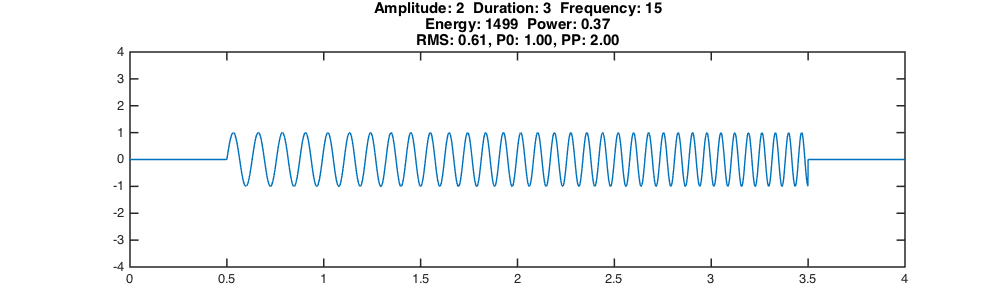

In [2]:
%plot -s 1000,300

%% signal parameters %%

% inputs
a = 2;          % signal amplitudes
f = 15;         % signal frequencies
d = 3;          % signal durations
D = 4;          % total duration
Fs = 1e3;       % sampling frequency

% calculated params
dt = 1/Fs;      % sample interval
n = Fs*d;       % length of signal (samples)
N = Fs*D;       % length of signal (samples)
s0 = N/2-n/2;   % start of signal (samples)
t = 0:dt:d-dt;  % timesteps of signal
T = 0:dt:D-dt;  % timesteps of total

%% create signal %%

% uncomment one of the examples below

% create signal: white noise
% y = a/2*randn(1,n);

% create signal: sine wave
%y = a*sin(2*pi*f*t);

% create signal: pulse
%y = a*gauspuls(t,f,0.5,-30);
    
% create signal: pulsetrain
%npls = 3; % number of pulses
%y_pulse = a*gauspuls(t,f,0.5,-30); % single pulse
%pls = y_pulse(1:floor(n/npls)); % crop single pulse
%pls = repmat(pls,1,npls); % repeat single pulse
%y = zeros(1,n); % allocate signal array
%y(1:length(pls)) = pls; % combine array

% create signal: chirp 
y = chirp(t,f/2,d,f,'linear', -90);

% pad signal
pad = zeros(1,s0);
Y = [pad y pad];

%% calculate metrics %%

% calculate energy
E = sum(abs(Y).^2);

% calculate power
P = E / N;

% calculate RMS
RMS = sqrt(P);

% calculate zero to peak
P0 = max(abs(Y));

% calculate peak to peak
PP = max(Y)-min(Y);            

%% plot %%

plot(T, Y)
ylim([-max(a) max(a)]*2)
title({sprintf('Amplitude: %1d  Duration: %1d  Frequency: %1d', a, d, f),...
sprintf('Energy: %.0f  Power: %.02f', E, P),...
sprintf('RMS: %.02f, P0: %.02f, PP: %.02f', RMS, P0, PP)})   

### Advanced example

Repeatedly copying and pasting the same code over and over again can be annoying and error-prone work. It also almost always is a symptom of poor programming practices. This section gives an example of how to build a function to automatically loop through the simple example above for every combination of a set of parameters. This is particularly desirable because if you would like to edit or correct the code, you need only do so in one place before you can reproduce all your results.

#### Common parameters

First we need to define a set of common parameters. Instead of single values, as in the simple example above, the variables `a`, `f`, and `d` are now vectors with multiple values we would like to test.

In [5]:
a = [1 2];      % signal amplitudes
f = [10 15];    % signal frequencies
d = [2 3];      % signal durations
D = 4;          % total duration
Fs = 1e3;       % sampling frequency

#### Define plotting function

This function loops through all combinations of the amplitudes (`a`), frequencies (`f`), and durations (`d`) given above and 1) creates the signal, 2) calculates some simple time domain metrics, and 3) plots the results.

In [6]:
%%file plot_time_metrics.m
function plot_time_metrics(signal_type,a,f,d,Fs,D)

dt = 1/Fs;      % sampling interval
N = Fs*D;       % length of total (samples)
T = 0:dt:D-dt;  % timesteps of total

cnt=1;
for(ii = 1:length(a))
    a_i = a(ii); % amplitude
    for(jj = 1:length(f))
        f_i = f(jj); % frequency
        for(kk = 1:length(d))
            d_i = d(kk); % duration

            % length of signal (samples)
            n = Fs*d_i;

            % start of signal (samples)
            s0 = N/2-n/2;

            % timesteps of signal
            t = 0:dt:d_i-dt;

            % create pad
            pad = zeros(1,s0);

            % create signal
            switch lower(signal_type)
                case 'noise'
                    y = a_i/2*randn(1,n);
                    f_i = NaN; % frequency doesn't apply here
                case 'sine'
                    y = a_i*sin(2*pi*f_i*t);
                case 'pulse'
                    y = a_i*gauspuls(t,f_i,0.5,-30);
                case 'pulsetrain'

                    % create single pulse
                    y_pulse = a_i*gauspuls(t,f_i,0.5,-30);

                    % number of pulses
                    npls = 3;

                    % crop single pulse
                    pls = y_pulse(1:floor(n/npls));

                    % repeat single pulse
                    pls = repmat(pls,1,npls);

                    % combine in zero-padded array
                    y = zeros(1,n);
                    y(1:length(pls)) = pls;

                case 'chirp'
                    y = chirp(t,f/2,d_i,f_i,'linear', -90);
            end

            % pad signal
            Y = [pad y pad];

            % calculate energy
            E = sum(abs(Y).^2);

            % calculate power
            P = E / N;

            % calculate RMS
            RMS = sqrt(P);

            % calculate zero to peak
            P0 = max(abs(Y));

            % calculate peak to peak
            PP = max(Y)-min(Y);

            % plot
            subplot(length(a)*length(f)*length(d)/2,2,cnt)
            plot(T, Y)
            ylim([-max(a_i) max(a_i)]*2)
            title({sprintf('Amplitude: %1d  Duration: %1d  Frequency: %1d', a_i, d_i, f_i),...
                sprintf('Energy: %.0f  Power: %.02f', E, P),...
                sprintf('RMS: %.02f, P0: %.02f, PP: %.02f', RMS, P0, PP)})   

            % update counter
            cnt=cnt+1;
        end
    end
end
set(gcf, 'PaperPosition', [0 0 20 24]); % increase figure size
return

Created file '/Users/hansenjohnson/Projects/intro-acoustics/docs/plot_time_metrics.m'.


### White noise

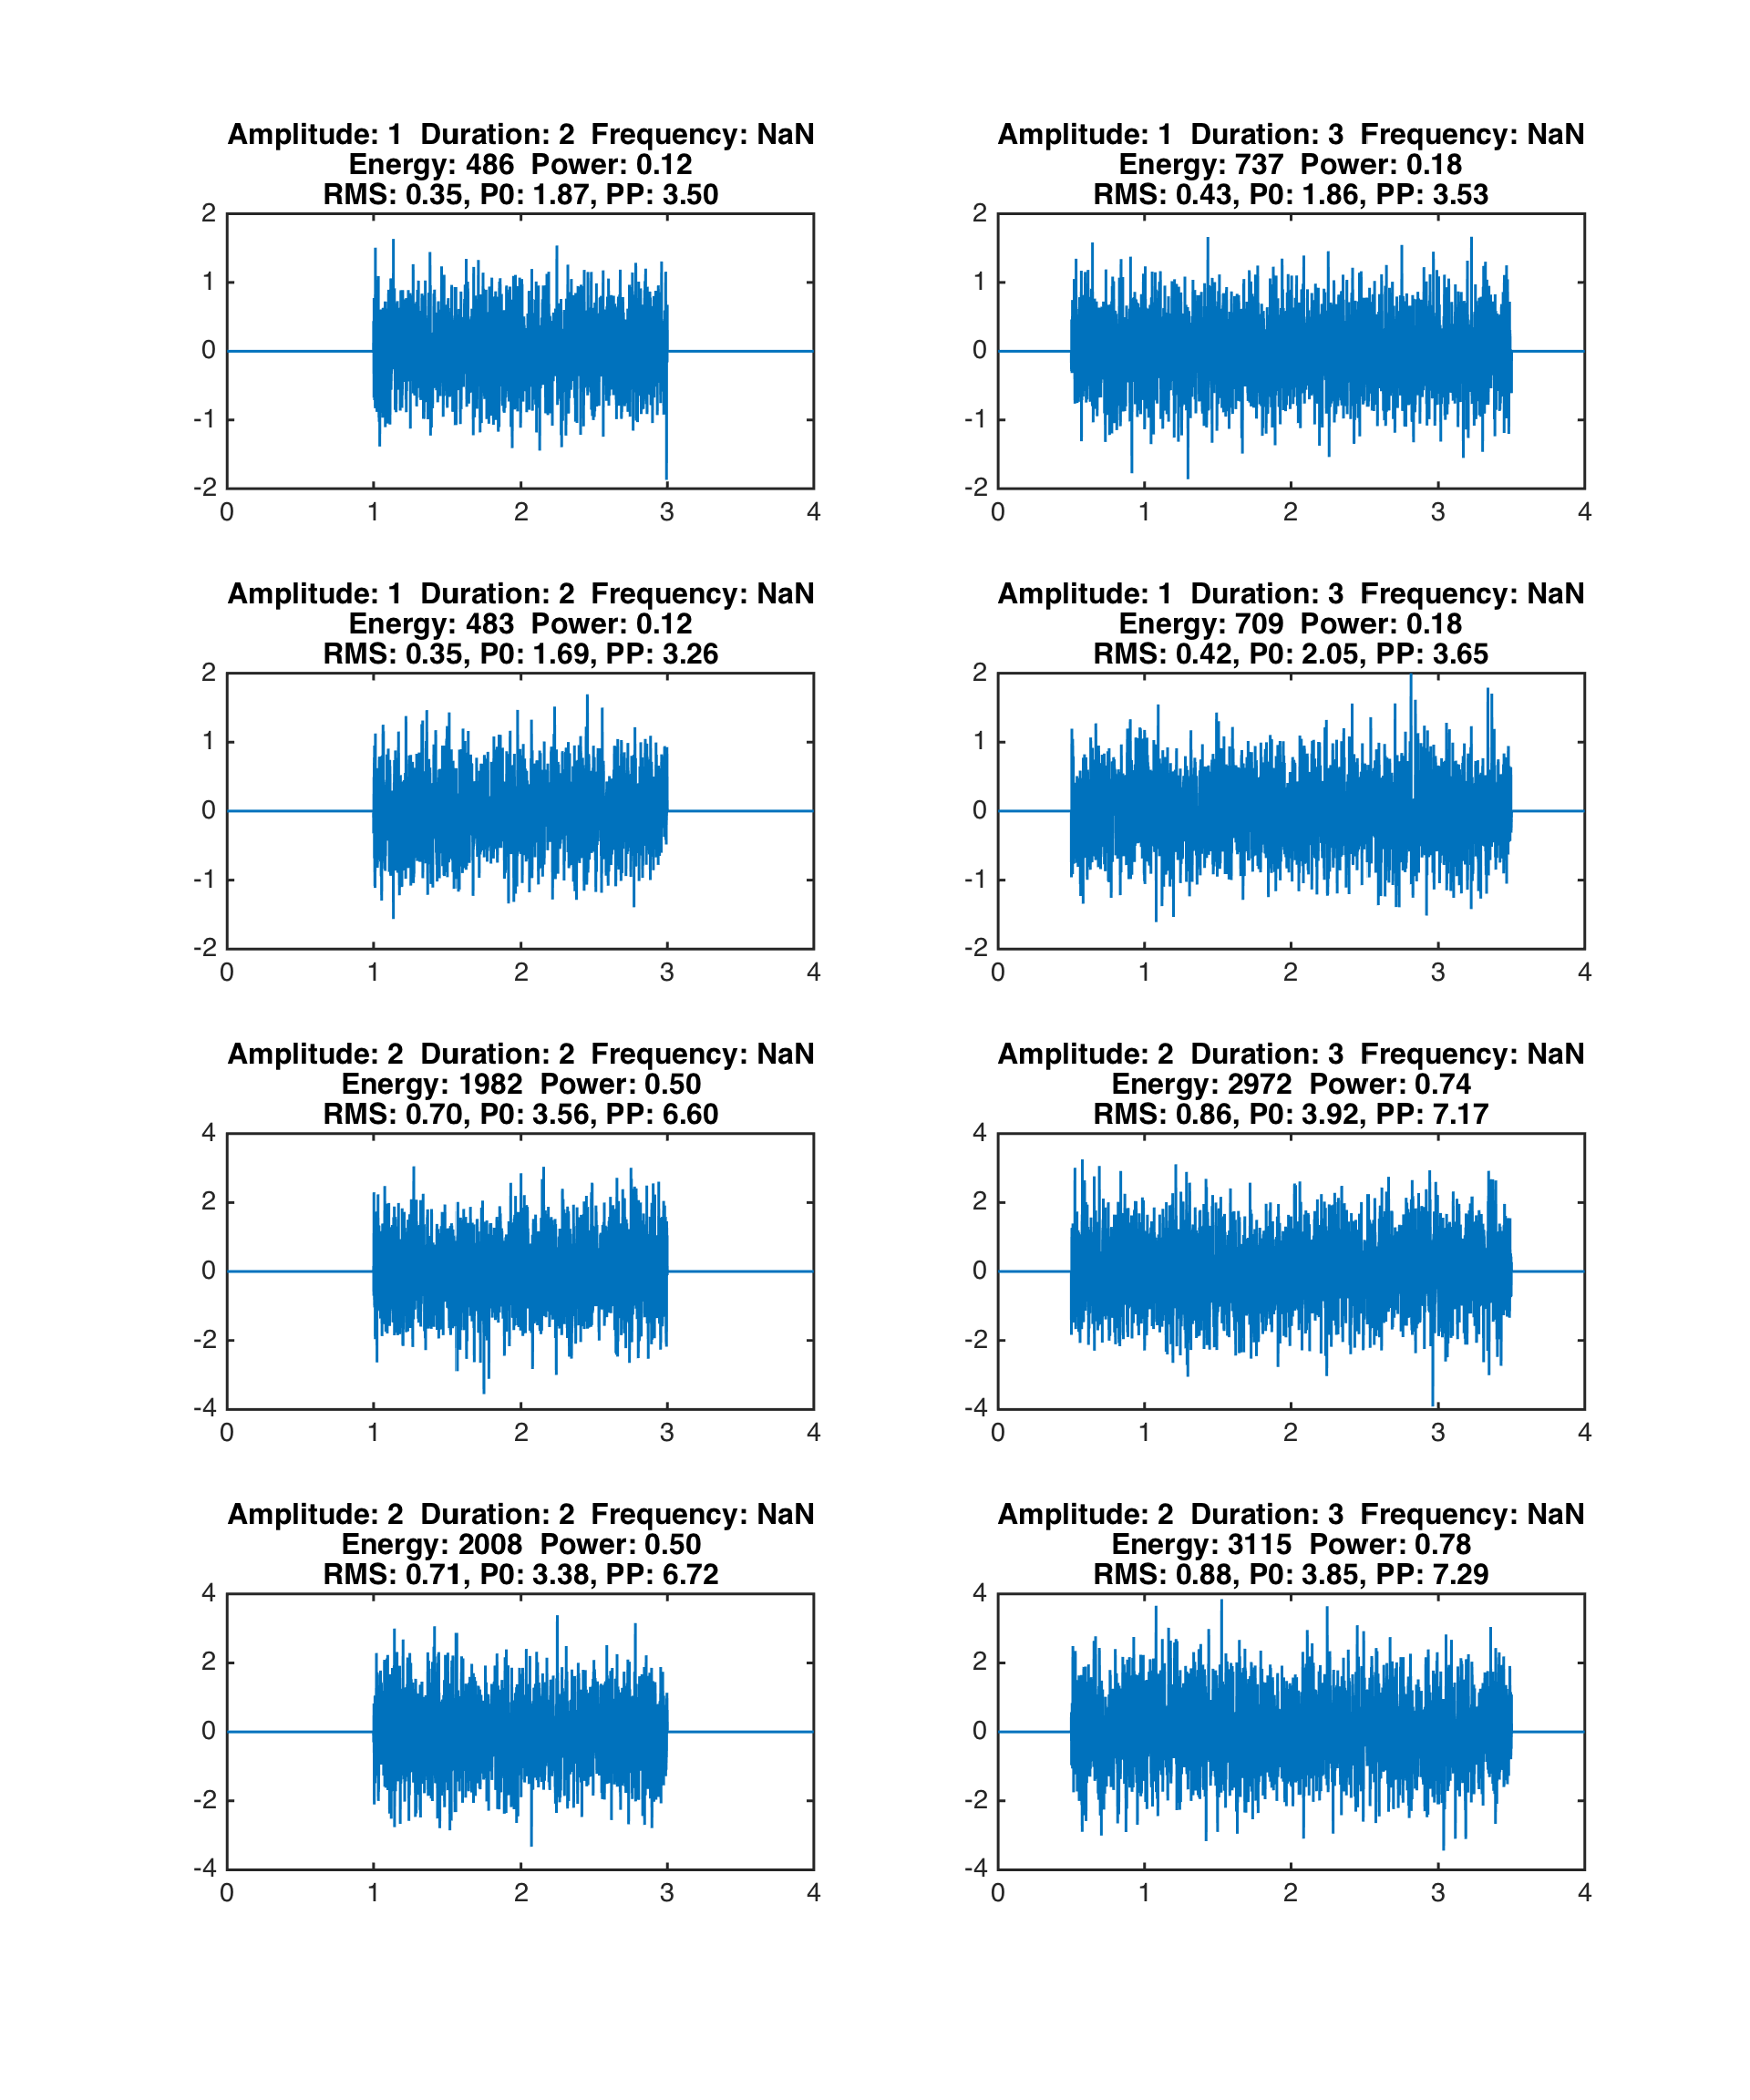

In [7]:
addpath docs
plot_time_metrics('noise',a,f,d,Fs,D);

### Sine wave

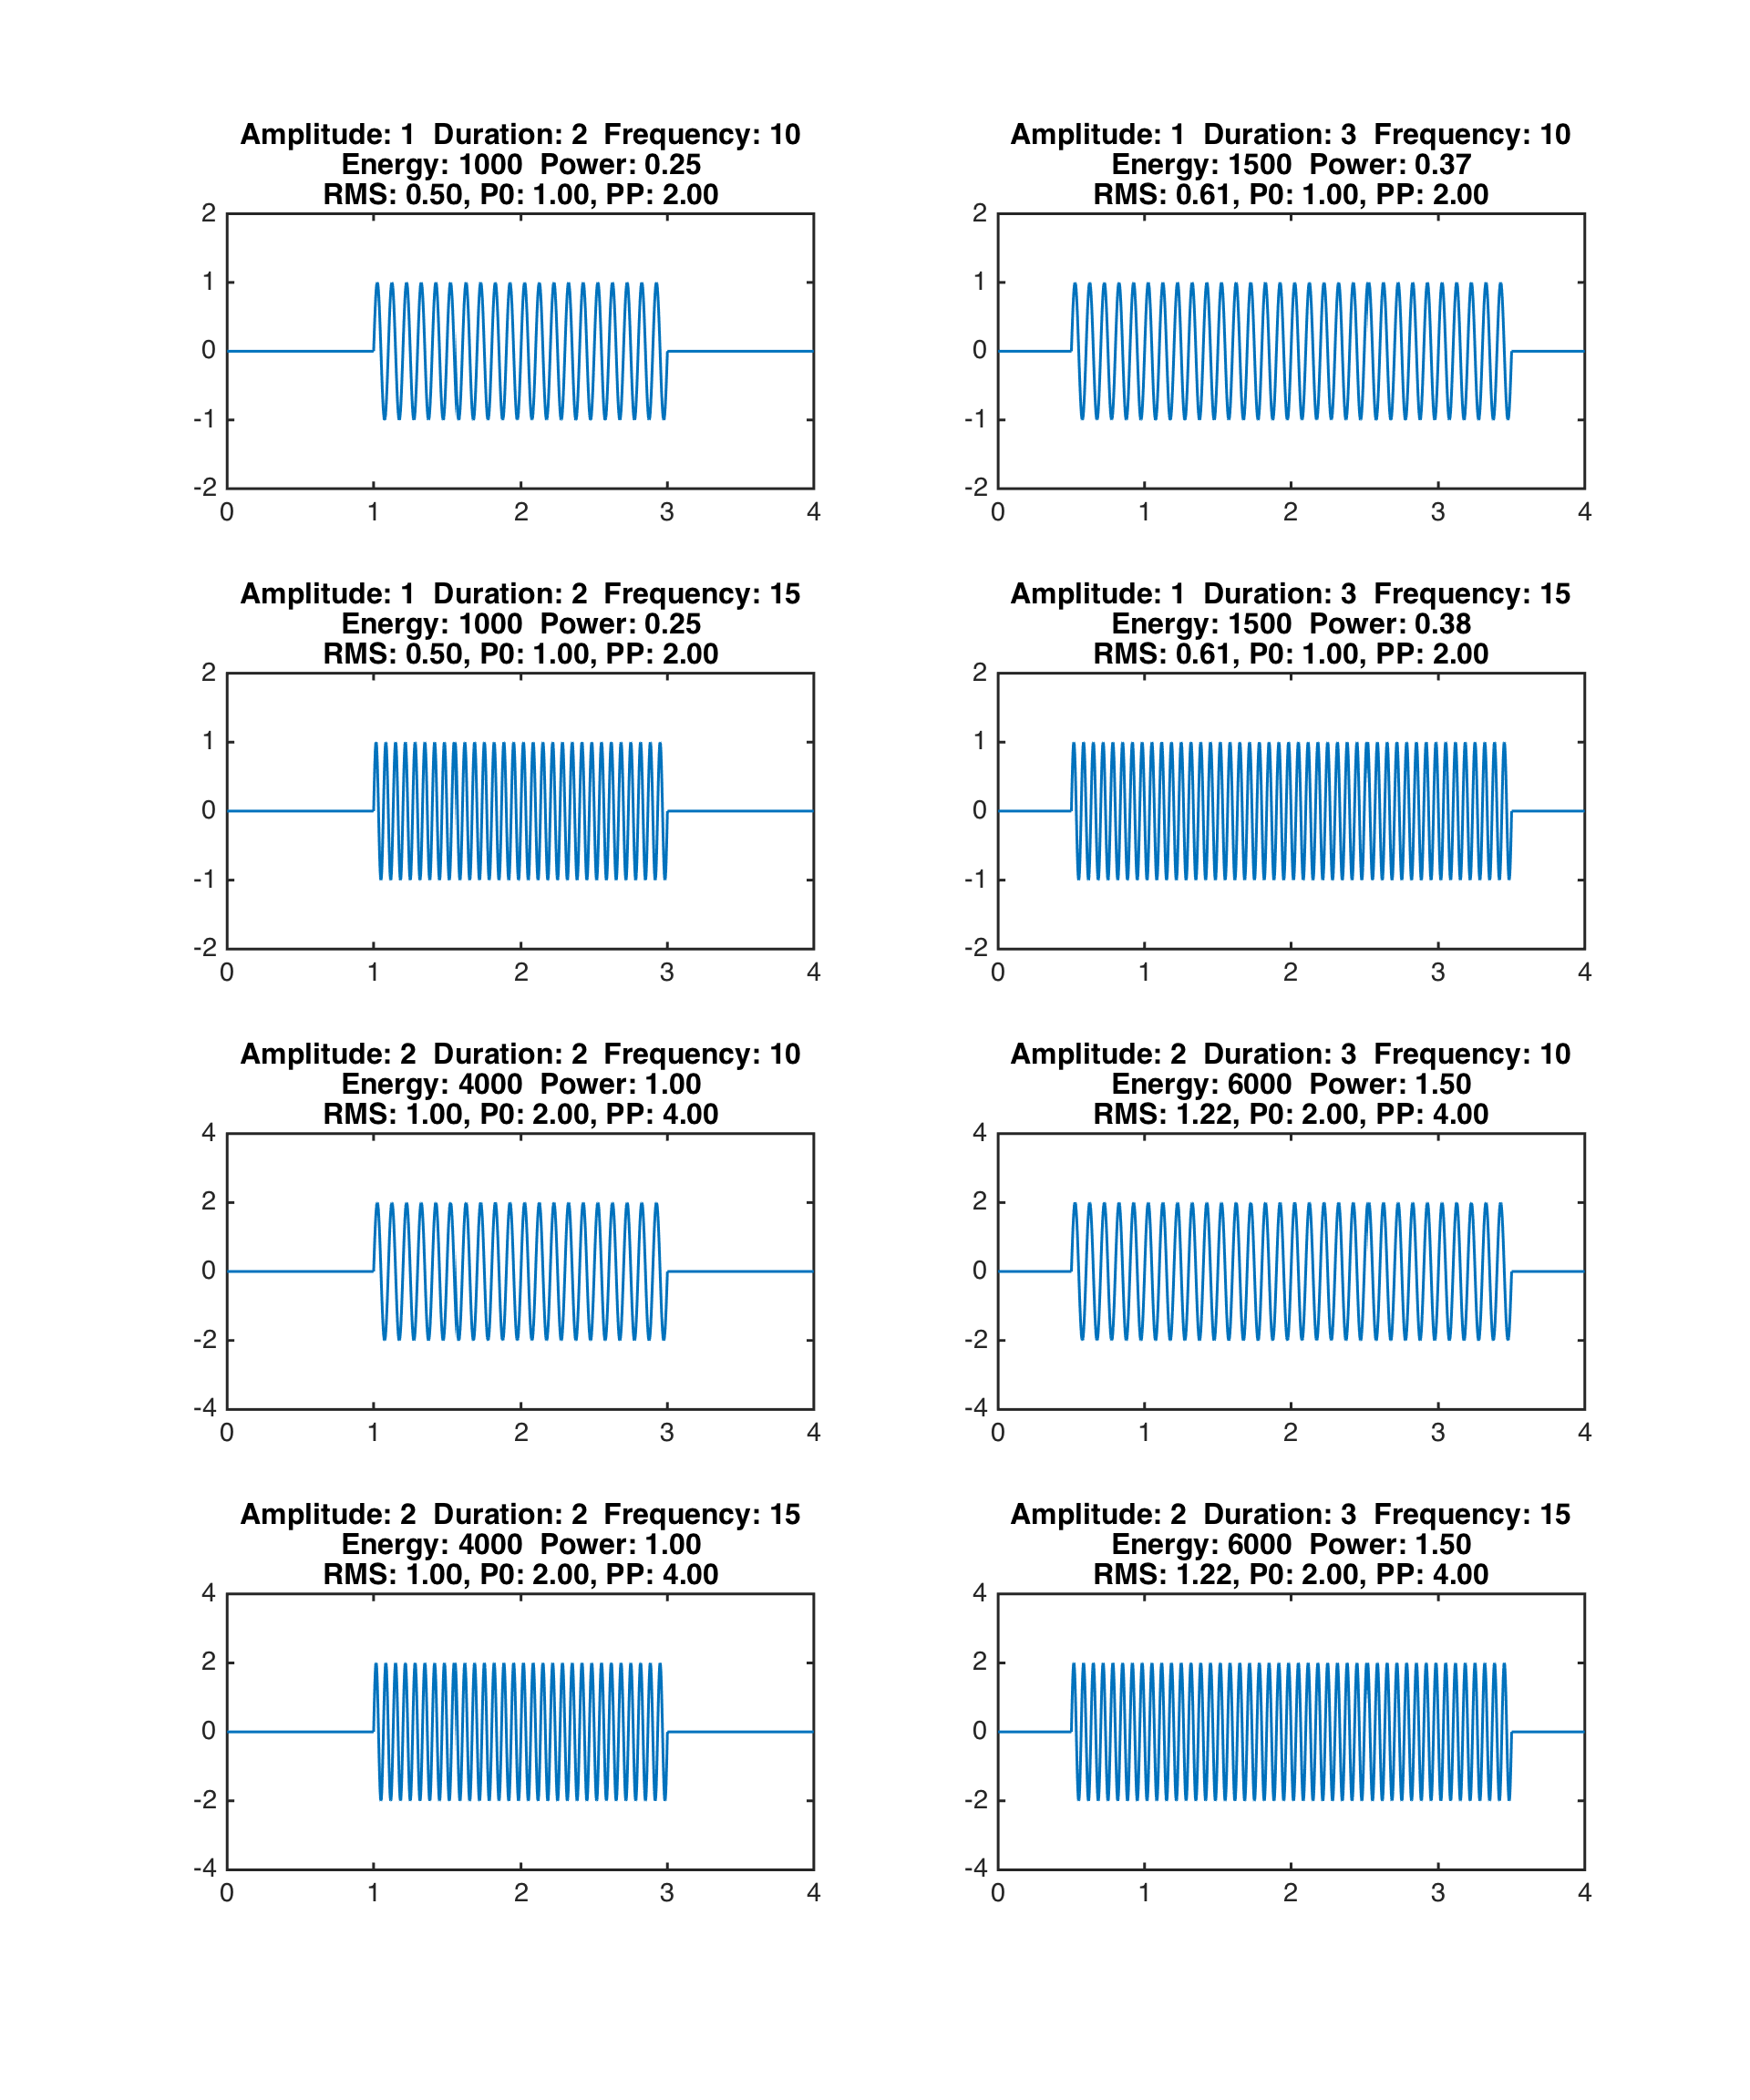

In [5]:
plot_time_metrics('sine',a,f,d,Fs,D);

### Pulse

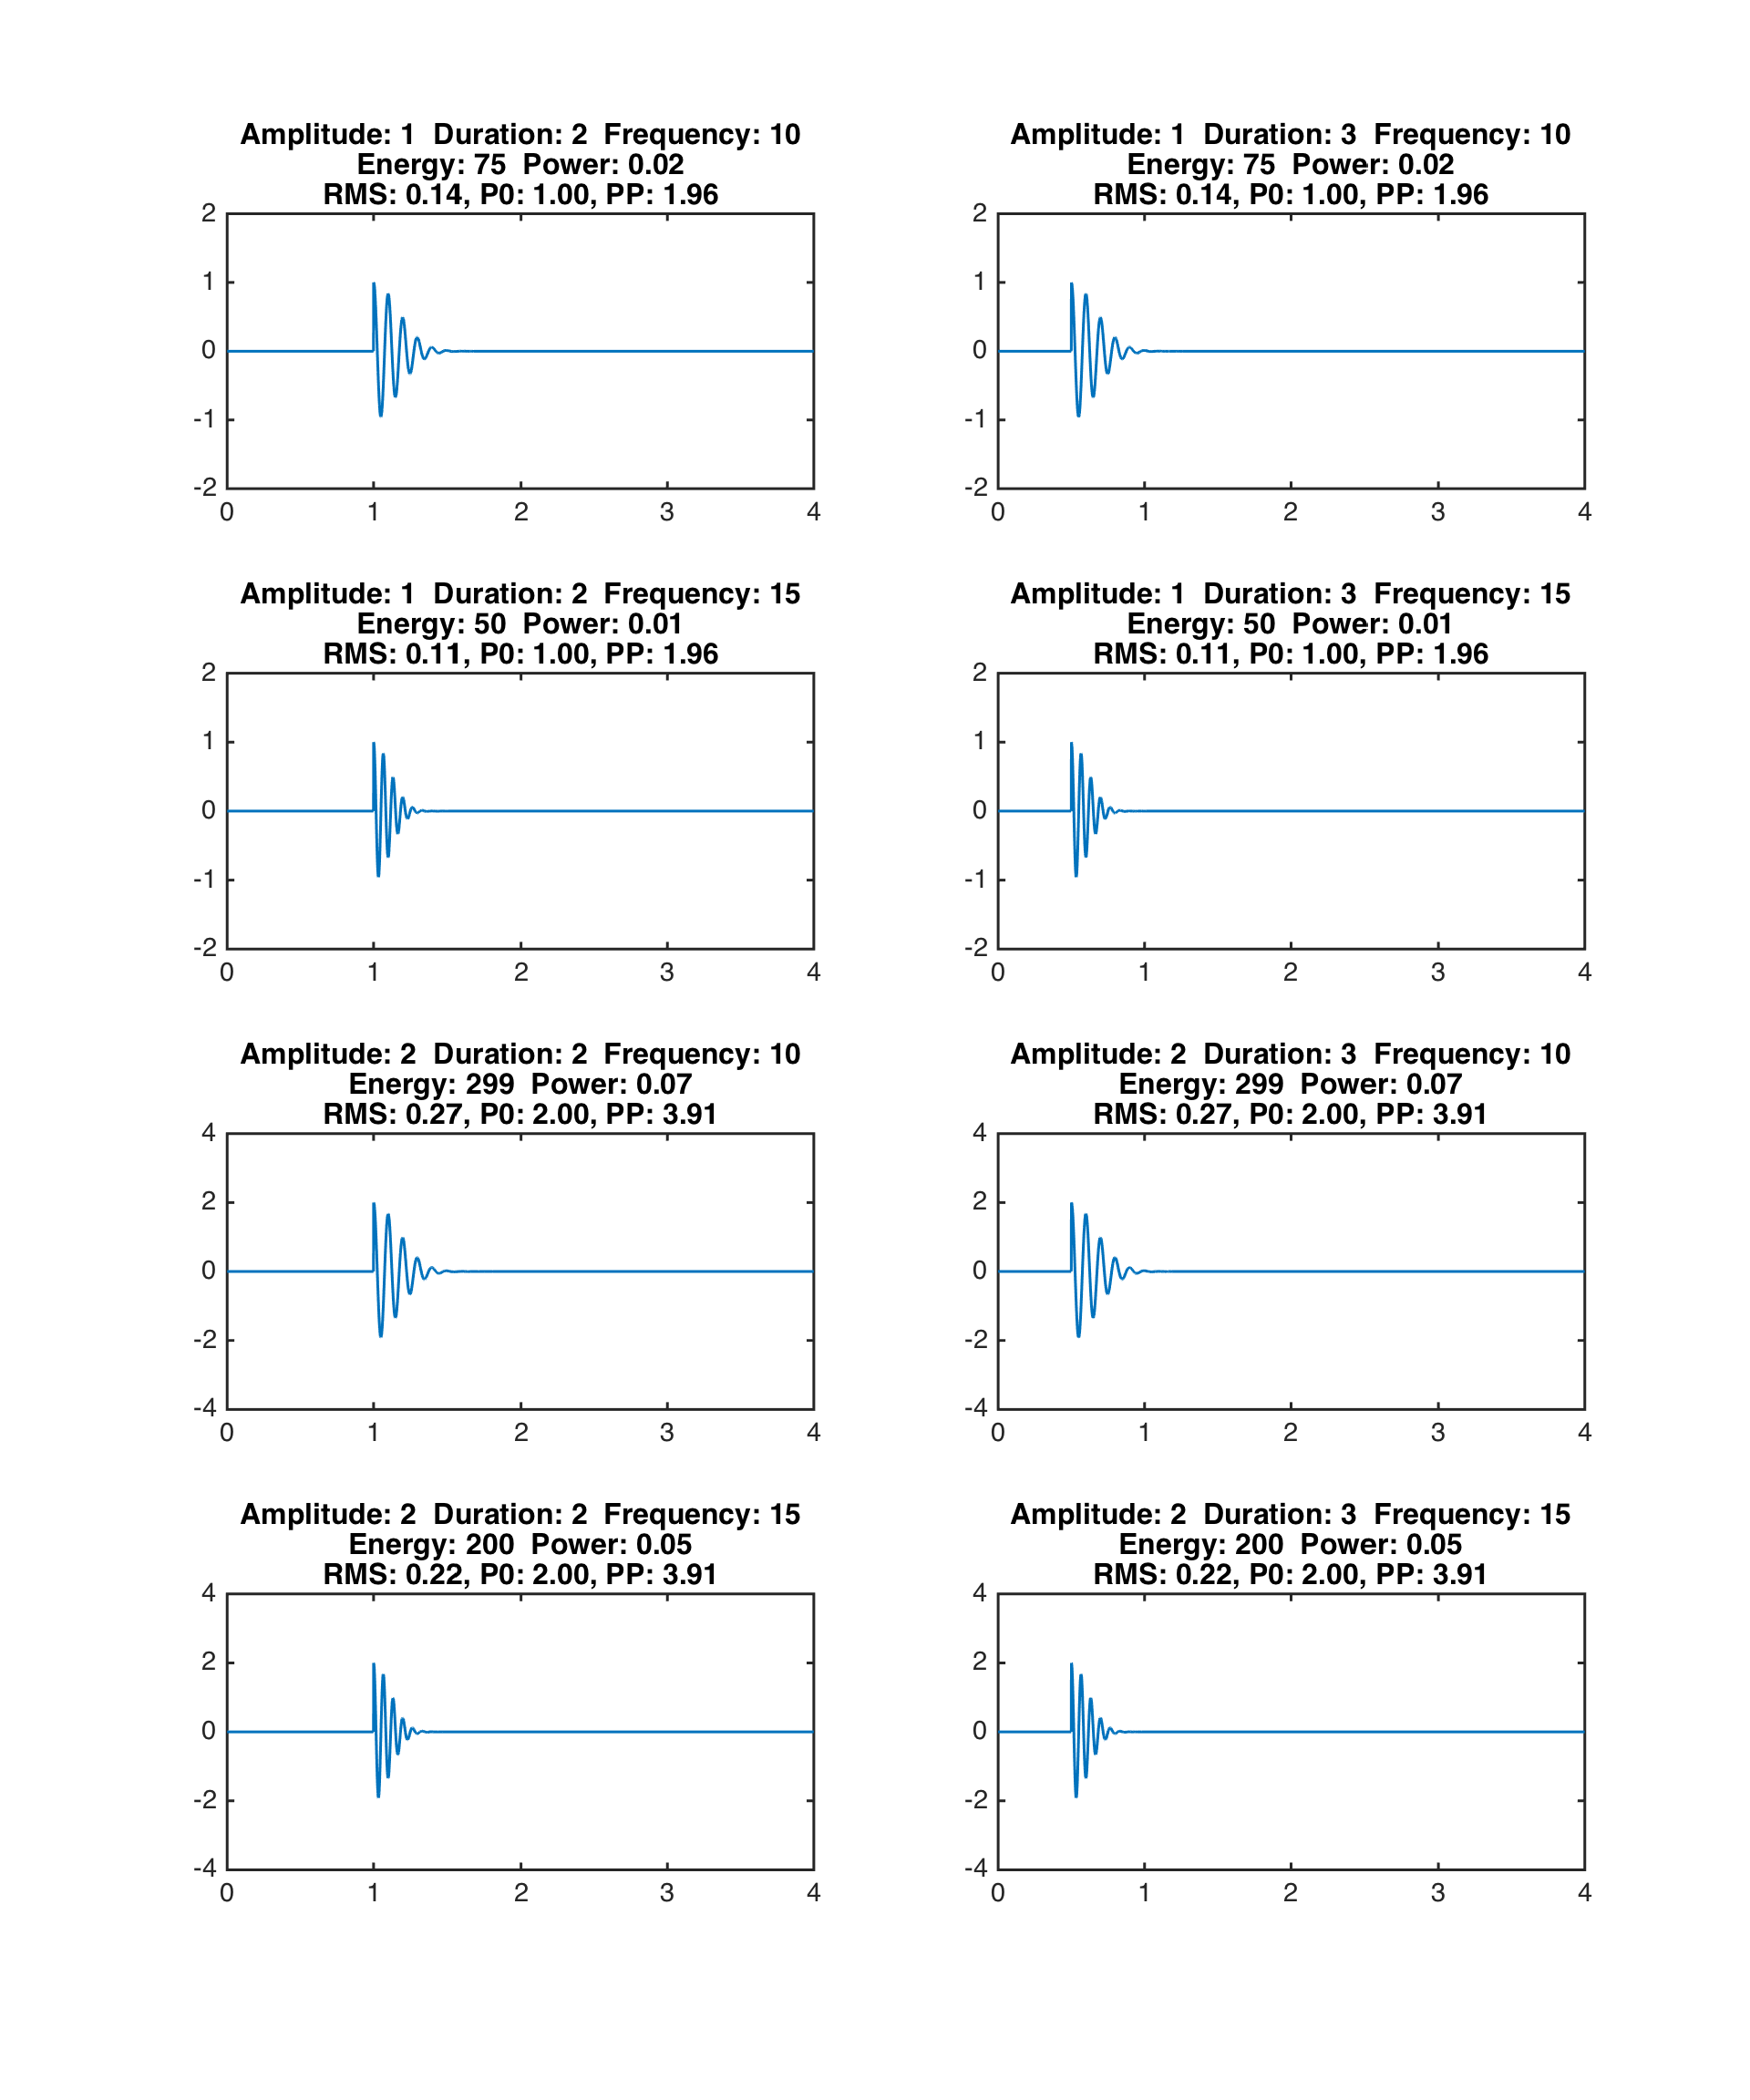

In [6]:
plot_time_metrics('pulse',a,f,d,Fs,D);

### Pulse train

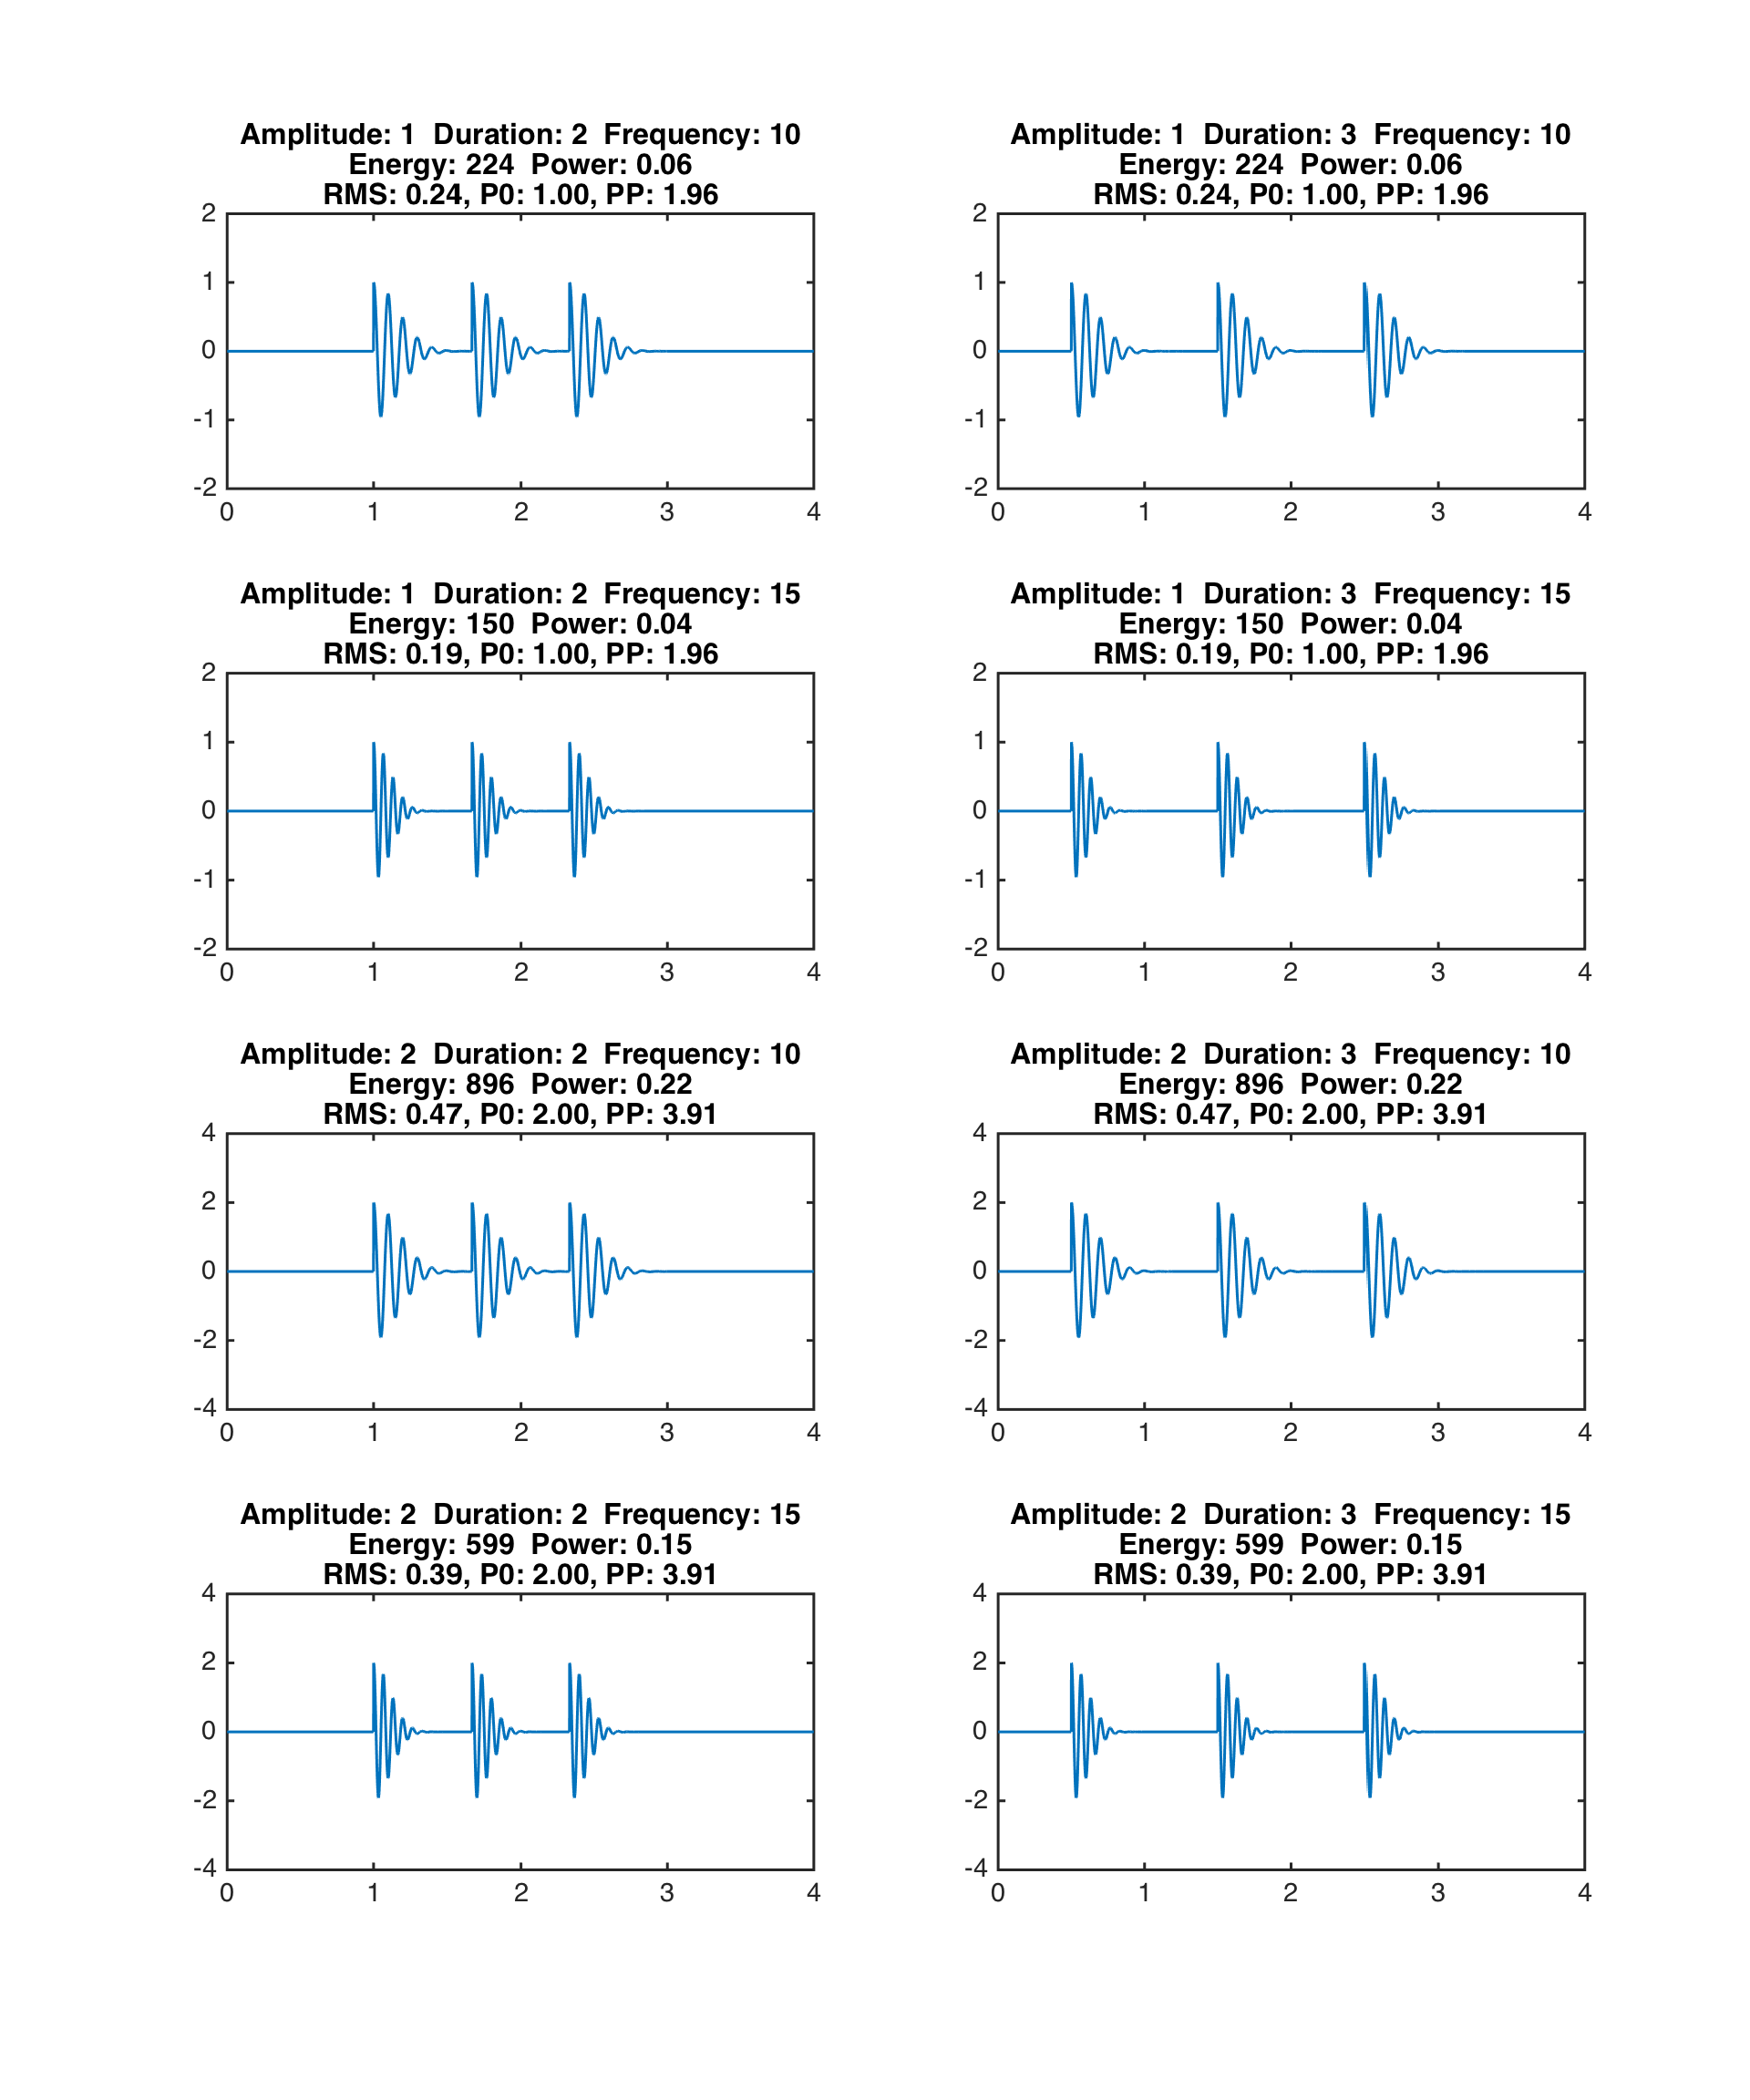

In [7]:
plot_time_metrics('pulsetrain',a,f,d,Fs,D);

### Chirp

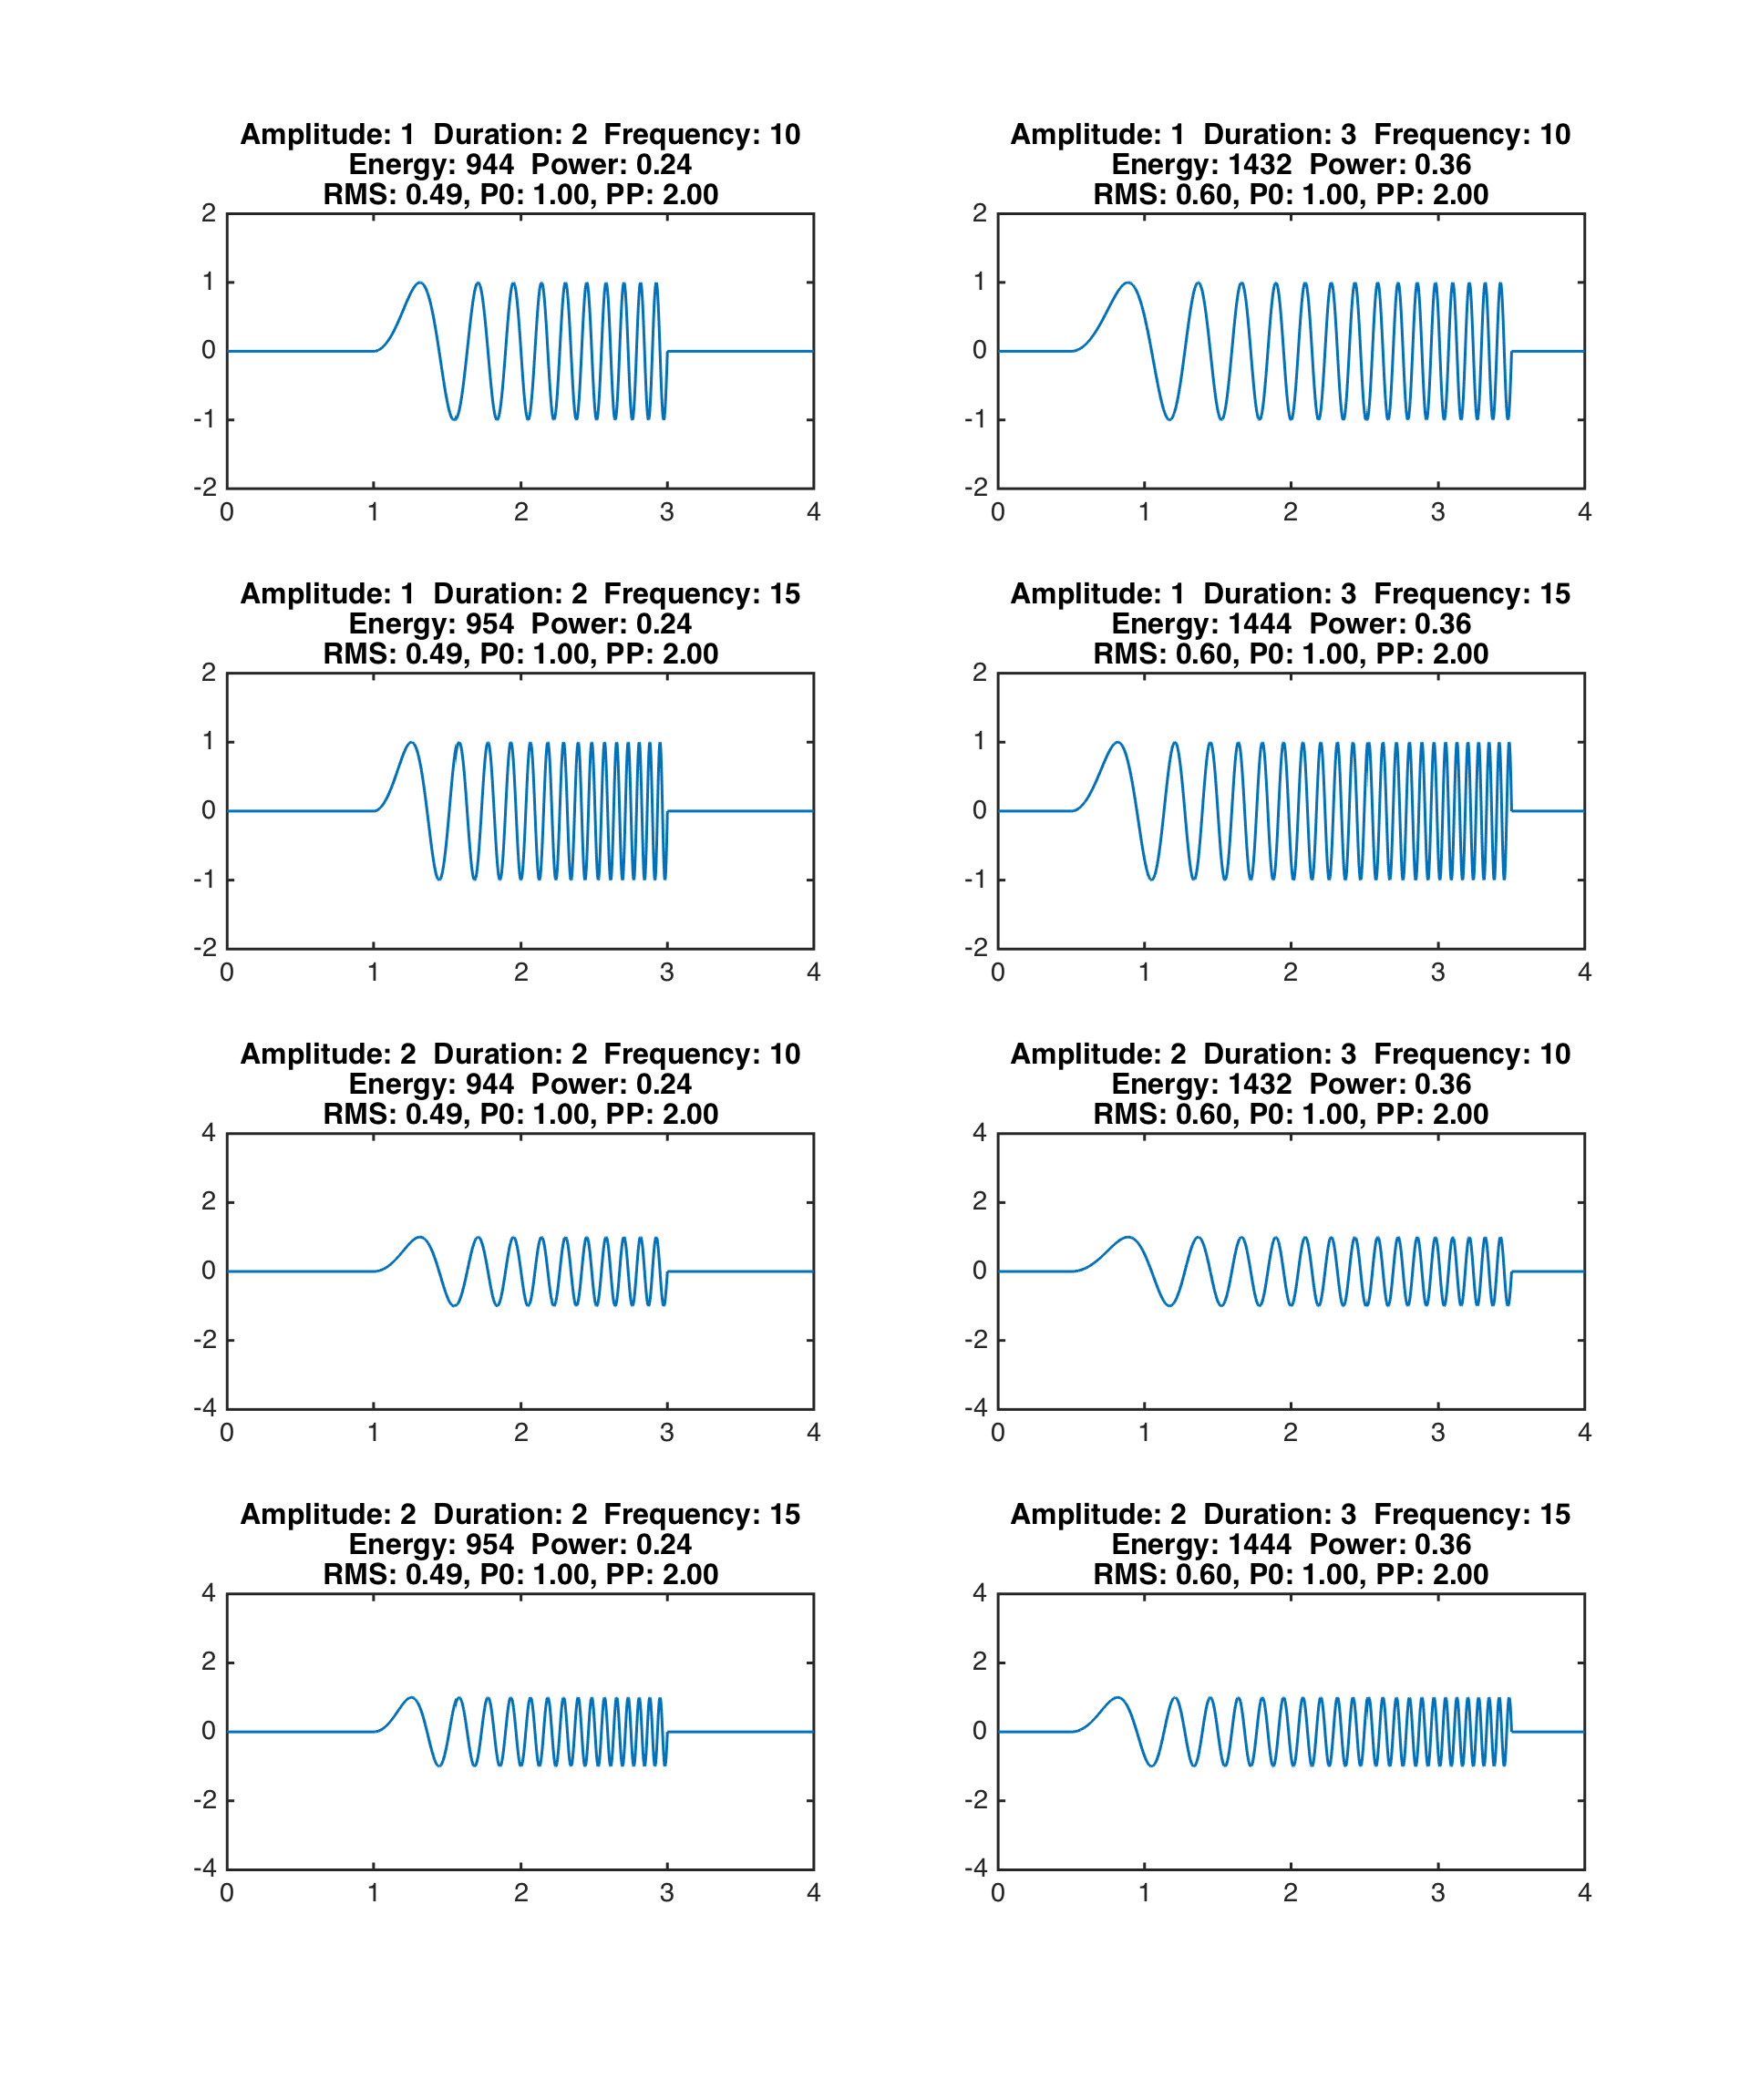

In [8]:
plot_time_metrics('chirp',a,f,d,Fs,D);